# Python On Resonance (PyOR)
## Everybody can simulate NMR

Author: Vineeth Thalakottoor 

Email: vineethfrancis.physics@gmail.com

## Tutorial 14: Avoided Crossing Part 1
#### Example: Spin-Lock Induced Crossing (SLIC)

## Load Python packages and define path to the source file "PythonOnResonance.py"

In [1]:
pathSource = '/media/HD2/Vineeth/PostDoc_Simulations/Github/PyOR_G/Source'

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import sys
sys.path.append(pathSource)

import PythonOnResonance as PyOR

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib notebook
import sympy as sp
from sympy import *

## Generating Spin System

In [3]:
"""
Define Spin quantum numbers of your spins in "Slist1".
Slist1[0] is spin of first particle and Slist1[1] is spin of second particle.
""";

Slist1 = [1/2,1/2]

In [4]:
"""
Define Planck constant equals 1. 
Because NMR spectroscopists are more interested to write Energy in frequency units. 
if False then hbarEQ1 = hbar
""";

hbarEQ1 = True

In [5]:
"""
Generate Spin Operators
""";

System = PyOR.Numerical_MR(Slist1,hbarEQ1)

"""
Sx, Sy and Sz Operators
""";
Sx,Sy,Sz = System.SpinOperator()

"""
S+ and S- Operators
""";
Sp,Sm = System.PMoperators(Sx,Sy)

## Zeeman Hamiltonian in Lab Frame

In [6]:
"""
Gyromagnetic Ratio
Gamma = [Gyromagnetic Ratio spin 1, Gyromagnetic Ratio spin 1, ...]
""";
Gamma = [System.gammaH1,System.gammaH1]

"""
Define the field of the spectromter, B0 in Tesla.
"""
B0 = 4.7

"""
Define the chemical Shift of individual spins
Offset = [chemical Shift spin 1, chemical Shift spin 1, ..]
"""
Offset = [0,2.8] # Offset frequency in Hz
deltaV = Offset[1] - Offset[0] # Frequency difference between Spin 1 and 2
"""
Function "LarmorF" give the list Larmor frequencies of individual spins in lab frame
"""
LarmorF = System.LarmorFrequency(Gamma,B0,Offset)

Hz = System.Zeeman(LarmorF,Sz)

Larmor Frequency in MHz:  [-200.11400882 -200.11401162]


## Initialize Density Matrix

In [7]:
"""
We will generate Initial Density Matrix in two ways: 
First we will generate a density matrix as we prefer say, Sz. 
Second we will create density matrix at thermal equlibrium

First Case
""";

Thermal_DensMatrix = False 

if Thermal_DensMatrix:
    Hz_EnUnit = System.Convert_FreqUnitsTOEnergy(Hz)
    HT_approx = False # High Temperature Approximation is False
    T = 300 # Temperature in Kelvin
    rho_in = System.EqulibriumDensityMatrix(Hz_EnUnit,T,HT_approx)
    rhoeq = rho_in.copy()   
else:
    rho_in = np.sum(Sz,axis=0) # Initial Density Matrix
    rhoeq = np.sum(Sz,axis=0)  # Equlibrium Density Matrix   
    print("Trace of density metrix = ", np.trace(rho_in))

Trace of density metrix =  0j


## Zeeman Halitonian in Rotating Frame

In [8]:
off = -2*np.pi*deltaV/2 
OmegaRF = [-System.gammaH1*B0 + off ,-System.gammaH1*B0 + off] # RF iradiation in the middle of spin frequencies
Hzr = System.Zeeman_RotFrame(LarmorF, Sz, OmegaRF)

## J Coupling Hamiltonian

In [9]:
"""
Define J couplings between individual spins
"""

Jlist = np.zeros((len(Slist1),len(Slist1)))
Jlist[0][1] = 17.4
Hj = System.Jcoupling(Jlist,Sx,Sy,Sz)

## Calculating the eigen values and vectors when B1 Field Amplitude is varied.

In [10]:
B1_Amp = np.linspace(1,33.8,1000) # In Hz
dim = System.Vdim
EiVa = np.zeros((B1_Amp.shape[-1],dim))
EVRef = np.zeros((B1_Amp.shape[-1],dim,dim))
j = 0

for i in B1_Amp:
    Omega1 = [i,i]
    Omega1Phase = [0,0]
    Hrf = System.Zeeman_B1(Sx,Sy,Omega1,Omega1Phase)
    Hslic = Hzr + Hj + Hrf
    
    Hslic_1 = np.array(Hslic,dtype="float64")
    eigenValues, EV = np.linalg.eigh(Hslic_1)
    
    if j == 0:
        
        EiVa[0] = eigenValues
        EVRef[0] = EV
        
    else:
        
        for m in range(dim):
            EVRef[j][:,m] = EV[:,np.argmax(np.absolute(EV.T @ EVRef[j-1][:,m]))] 
            # For arranging the eigen vector in order w.r.t to first set of eigen vectors
            # I believe this method is a general way of ordering eigen vectors.
                    
        EiVa[j] = (EVRef[j].T@Hslic_1@EVRef[j]).diagonal() 

    j = j + 1

/tmp/ipykernel_2655496/660284760.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  Hslic_1 = np.array(Hslic,dtype="float64")


In [11]:
"""
Initial Eigen States
""";

intialState_1 = EVRef[0][:,0]
intialState_2 = EVRef[0][:,1]
intialState_3 = EVRef[0][:,2]
intialState_4 = EVRef[0][:,3]

In [12]:
"""
Final Eigen States
""";

finalState_1 = EVRef[-1][:,0]
finalState_2 = EVRef[-1][:,1]
finalState_3 = EVRef[-1][:,2]
finalState_4 = EVRef[-1][:,3]

## Mixing of states

In [13]:
print("Dot product between intial state 1 and final sate 1: ",np.dot(intialState_1,finalState_1))
print("They are almost orthogonal")

Dot product between intial state 1 and final sate 1:  -0.1195940574513697
They are almost orthogonal


In [14]:
print("Dot product between intial state 1 and final sate 2: ",np.dot(intialState_1,finalState_2))
print("They are almost parallel")

Dot product between intial state 1 and final sate 2:  0.9922390524388365
They are almost parallel


In [15]:
print("Dot product between intial state 2 and final sate 1: ",np.dot(intialState_2,finalState_1))
print("They are almosty parallel")

Dot product between intial state 2 and final sate 1:  0.9925324930456398
They are almosty parallel


In [16]:
print("Dot product between intial state 2 and final sate 2: ",np.dot(intialState_2,finalState_2))
print("They are almost orthogonal")

Dot product between intial state 2 and final sate 2:  0.11865951767022453
They are almost orthogonal


In [17]:
print("Dot product between intial state 3 and final sate 3: ",np.dot(intialState_3,finalState_3))
print("They are almost parallel")

Dot product between intial state 3 and final sate 3:  1.0000000000000004
They are almost parallel


In [18]:
print("Dot product between intial state 4 and final sate 4: ",np.dot(intialState_4,finalState_4))
print("They are almost parallel")

Dot product between intial state 4 and final sate 4:  0.999020473587766
They are almost parallel


## Conclusion:
#### State 1 and 2 mix each other. But state 3 and 4 remains as they are.
That means,

State 1 becomes State 2 

State 2 becomes State 1 

State 3 remains State 3

State 4 remains State 4

## Plotting the Eigen Values

<IPython.core.display.Javascript object>


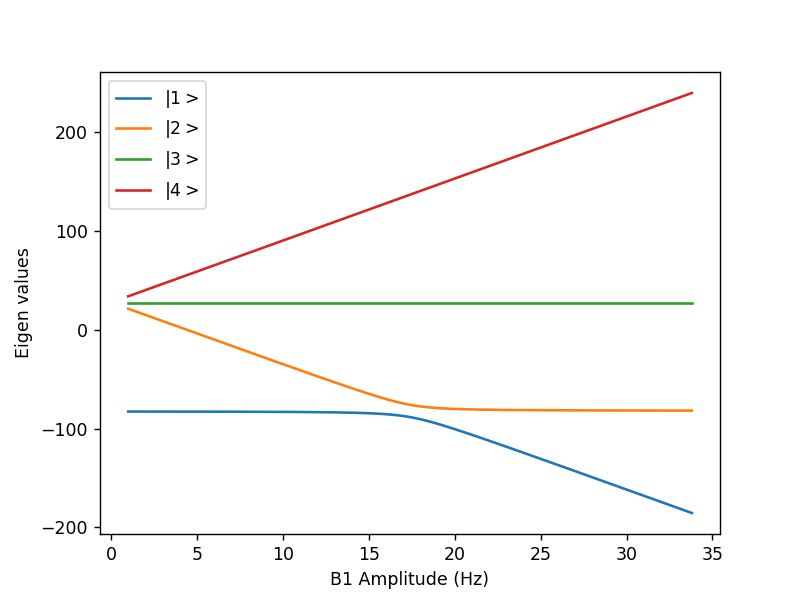

In [19]:
"""
Plotting the eigen value of four eigen states with respect to B1 amplitude of the RF.
Avoided crossing, when B1 (Amplitude) = J Coupling
""";

plt.figure(1)
plt.plot(B1_Amp,EiVa[:,0],"-",label=r"$|1>$")
plt.plot(B1_Amp,EiVa[:,1],"-",label=r"$|2>$")
plt.plot(B1_Amp,EiVa[:,2],"-",label=r"$|3>$")
plt.plot(B1_Amp,EiVa[:,3],"-",label=r"$|4>$")
plt.xlabel("B1 Amplitude (Hz)")
plt.ylabel("Eigen values")
plt.legend()

## Any suggestion? write to me
If you see something is wrong please write to me, so that the PyOR can be error free. 

vineethfrancis.physics@gmail.com